# Bonus Exercise

<div class="alert alert-warning">
<h2>Objective:</h2>

The following tasks are aimed to help you gain deeper insight when implementing an A/B test. The insight gained from this exercise will help you understand the importance of the following aspects of an A/B test:

- Probability of making an error and the subsequent impact on the conversion rate
- The number of samples required to run an A/B test. Or the duration for which the A/B test should be run
 
</div>

Consider a scenario where you have implemented an A/B test with the following specifications:

- You assumed a $\beta(1,1)$ as the prior for both variants.
- You have 10 samples and 0.2 conversion rate for variant A.
- You have 10 samples and 0.3 conversion rate for variant B.
- You have obtained the posterior distributions of conversion rates for both variants.

You decide to stop the test and declare B as the winner. However, you are not sure if you have made the right decision. So, you decide to run a few checks. You find out that:

- About two third of times variant B happen to be better than variant A.
- On average, there is an about 4% loss in conversion rate by choosing variant B over variant A.

<div class="alert alert-info">
<h4>Task 1</h4>

Your task is to develop solution methods that give you the above mentioned quantities (two third as a probability, and 4% loss) using three different methods:

1. Closed form solution
2. Numerical approximation
3. Simulation i.e. based on the outcomes from PyMC
</div>

<div class="alert alert-info">
<h4>Task 2</h4>

You realize that the 4% loss in conversion rate is not acceptable. So, you decide to collect more samples. But at some point you have to stop the test. You decide to stop the test when the loss in conversion rate drops below 1%. How many more samples you need to collect to drop the loss to less than 1%? For simplicity assume that $N_A$ = $N_B$.

</div>


<div class="alert alert-success">

Hint: given $\theta_A \sim \beta(a_1,b_1)$ and $\theta_B \sim \beta(a_2,b_2)$ as posterior distributions for the conversion rates of variants A and B, we can show that:

\begin{align*}
P(\theta_B > \theta_A) &= 1- H(a_1,b_1,a_2,b_2)
\end{align*}

where $H(a_1,b_1,a_2,b_2)$ can be calculated using the following function:



```
from scipy.special import gamma

def compute_H(a_1,b_1,a_2,b_2):
    prob = 0
    for i in range(a_2):
        prob += gamma(a_1+i)*gamma(b_1+b_2)*gamma(1+b_2+i)*gamma(a_1+b_1)/gamma(a_1+b_1+b_2+i)/gamma(1+i)/gamma(b_2)/gamma(a_1)/gamma(b_1)/(b_2+i)
    return 1-prob
```
</div>


Solution:

In [1]:
import numpy as np
import pandas as pd
from scipy.special import gamma
from scipy.stats import beta
import matplotlib.pyplot as plt

## Loss function in Bayesian A/B testing
### Closed form solution

Let's assume that $\theta_A \sim \beta(a,b)$ and $\theta_B \sim \beta(c,d)$ with $\beta(a,b) = \frac{1}{B(a,b)} \theta^{a-1}(1-\theta)^{b-1}$

Since $\theta_A$ and $\theta_B$ are independent, we can show that:

\begin{align*}
P(\theta_B > \theta_A) = 1- H(a,b,c,d)
\end{align*}

where $H(a,b,c,d)=1 - \sum_{i=0}^{c-1} \frac{B(a+i,b+d)}{B(1+i,d)B(a,b)(d+i)}$ and $ B(a,b)= \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}$

Similarly, the loss due to choosing B can be calculated as:

\begin{align*} 
E[L_B] = \frac{B(a+1,b)}{B(a,b)} \times H(a+1,b,c,d) - \frac{B(c+1,d)}{B(c,d)} \times H(a,b,c+1,d)
\end{align*}



In [2]:
# write a function to compute the $P(\theta_B > \theta_A)$ based on the above formula

def compute_prob(a,b,c,d):

    prob = 0
    for i in range(c):
        prob += gamma(a+i)*gamma(b+d)*gamma(1+d+i)*gamma(a+b)/gamma(a+b+d+i)/gamma(1+i)/gamma(d)/gamma(a)/gamma(b)/(d+i)
    return prob

# let's compute H

def compute_H(a,b,c,d):

    prob = 0
    for i in range(c):
        prob += gamma(a+i)*gamma(b+d)*gamma(1+d+i)*gamma(a+b)/gamma(a+b+d+i)/gamma(1+i)/gamma(d)/gamma(a)/gamma(b)/(d+i)
    return 1-prob

# let's compute the loss function L 

def get_loss(a,b,c,d):

    loss  = gamma(a+1)*gamma(a+b)/gamma(a+b+1)/gamma(a) * compute_H(a+1,b,c,d)
    loss -= gamma(c+1)*gamma(c+d)/gamma(c+d+1)/gamma(c) * compute_H(a,b,c+1,d)
    return loss

We have all the necessary functions to calculate the probability and the loss function. Let's calculate them for the given scenario:

In [3]:
N_A, N_B = 10, 10
success_A, success_B = 2, 3

a = success_A + 1
b = N_A - success_A + 1

c = success_B + 1
d = N_B - success_B + 1

In [4]:
print(a,b,c,d)

print('probability that theta_B > theta_A: ', 100*np.round(compute_prob(a,b,c,d),3))
print('probability that theta_A > theta_B: ', 100*np.round(compute_H(a,b,c,d),3))
print('loss function if B is deployed: ', 100*np.round(get_loss(a,b,c,d),2))

3 9 4 8
probability that theta_B > theta_A:  68.2
probability that theta_A > theta_B:  31.8
loss function if B is deployed:  4.0


### Numerical solution

3 9 4 8


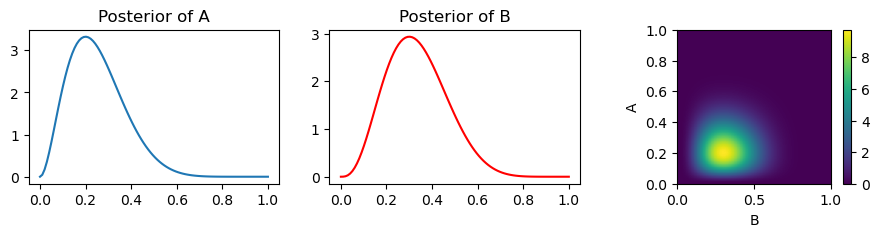

In [5]:
print(a,b,c,d)

k = 100
x = np.linspace(0,1,k)

posteriorA = beta.pdf(x, a,b)
posteriorB = beta.pdf(x, c,d)

joint_posterior = np.zeros(shape=(k, k)) 
for i in range(k):
    for j in range(k):
        joint_posterior[i,j] = posteriorA[i] * posteriorB[j]

# posterior of A
fix,axes = plt.subplots(1,3,figsize=(11,2))
axes[0].plot(x,posteriorA)
axes[0].set_title('Posterior of A')

# posterior of B
axes[1].plot(x,posteriorB,'Red');
axes[1].set_title('Posterior of B')

# joint posterior
im=axes[2].imshow(joint_posterior, extent=[0,1,0,1], aspect=1, origin='lower')
plt.colorbar(im,ax=axes[2])
axes[2].set_ylabel('A')
axes[2].set_xlabel('B');

We can now calculate the probabilities using the joint posterior distributions of $\theta_A$ and $\theta_B$:

In [6]:
errorFunctionA = 0.0
for i in range(100):
    for j in range(i, 100):
        errorFunctionA += joint_posterior[i,j]*0.0001

errorFunctionB = 0.0
for i in range(100):
    for j in range(0,i):
        errorFunctionB += joint_posterior[i,j]*0.0001

print('probability that theta_B > theta_A: ', 100*np.round(errorFunctionA,2))
print('probability that theta_A > theta_B: ',100*np.round(errorFunctionB,2))

probability that theta_B > theta_A:  68.0
probability that theta_A > theta_B:  30.0


In [7]:
# Computing the loss function
def compute_loss(i, j, var):
    if var == 'A':
        return max(j*0.01 - i*0.01, 0.0)
    if var == 'B':
        return max(i*0.01 - j*0.01, 0.0)

In [8]:
lossFunctionA, lossFunctionB = 0.0, 0.0 
for i in range(100):
    for j in range(100):
        lossFunctionA += joint_posterior[i,j] * compute_loss(i,j,'A')*0.0001
        lossFunctionB += joint_posterior[i,j] * compute_loss(i,j,'B')*0.0001

print('loss function if A is deployed: ', 100*np.round(lossFunctionA,2))
print('loss function if B is deployed: ', 100*np.round(lossFunctionB,2))

loss function if A is deployed:  12.0
loss function if B is deployed:  4.0


#### Investigate Sample Size vs Loss (Task 2)

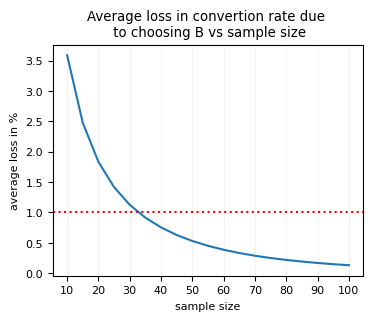

In [9]:
# let's write a couple of functions to compute the loss function for different sample sizes and generates a plot where we can see how the average loss changes as a function of the sample size. 

def compute_loss_vs_sample_size(N, success_rate_A, success_rate_B):

    loss = []
    for i in range(10,N+1,5):
        loss.append(compute_avg_loss(i, success_rate_A, success_rate_B))

    return loss


def compute_avg_loss(N, success_rate_A, success_rate_B):

    N_A, N_B = N, N

    success_A = success_rate_A*N_A
    success_B = success_rate_B*N_B

    a = success_A + 1
    b = N_A - success_A + 1

    c = success_B + 1
    d = N_B - success_B + 1

    posteriorA = beta.pdf(np.linspace(0,1,100), a,b)
    posteriorB = beta.pdf(np.linspace(0,1,100), c,d)

    joint_posterior = np.zeros(shape=(100,100)) 

    for i in range(k):
        for j in range(k):
            joint_posterior[i,j] = posteriorA[i] * posteriorB[j]

    lossFunctionB = 0.0
    for i in range(100):
        for j in range(100):
            lossFunctionB += joint_posterior[i,j] * compute_loss(i,j,'B')*0.0001
    
    return lossFunctionB

# let's plot the loss function as a function of the sample size
loss = compute_loss_vs_sample_size(N=100, success_rate_A=0.2, success_rate_B=0.3)

fig = plt.figure(figsize=(4,3))
plt.rcParams.update({'font.size': 8})


plt.plot(np.arange(10,101,5), pd.Series(loss)*100,)
plt.axhline(y=1, color="red", linestyle=':')

plt.xlabel('sample size')
plt.ylabel('average loss in %')
plt.title('Average loss in conversion rate due \n to choosing B vs sample size')
plt.xticks(np.arange(10,101,10))
plt.grid(axis='x', color='0.95')
plt.show()

The loss drops from ~4% to ~1% when the sample size increases from 10 to 30. So, we need to collect 20 more samples to drop the loss to less than 1%.

### PyMC solution (Task 1 continued)
Instead of simulating Beta distributions, we can use PyMC to simulate the posterior distributions of $\theta_A$ and $\theta_B$ and then calculate the probabilities and loss function using the posterior samples.

In [10]:
# Load libraries
import arviz as az
import pymc as pm

In [11]:
with pm.Model() as example_model:

    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = [1,1], 
                    beta  = [1,1], 
                    shape = 2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Binomial("y", 
                      n        = [10, 10], 
                      observed = [2, 3], 
                      p        = theta,
                      shape    = 2) 
    
    # Difference between variants
    relative_uplift = pm.Deterministic("uplift", 
                                        theta[1] / theta[0] - 1)

    # Draw samples from the prior
    trace = pm.sample(draws=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


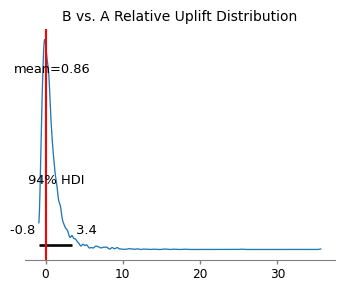

In [12]:
az.plot_posterior(trace.posterior["uplift"], figsize=(4, 3))

plt.title("B vs. A Relative Uplift Distribution", fontsize=10)
plt.axvline(x=0, color="red");

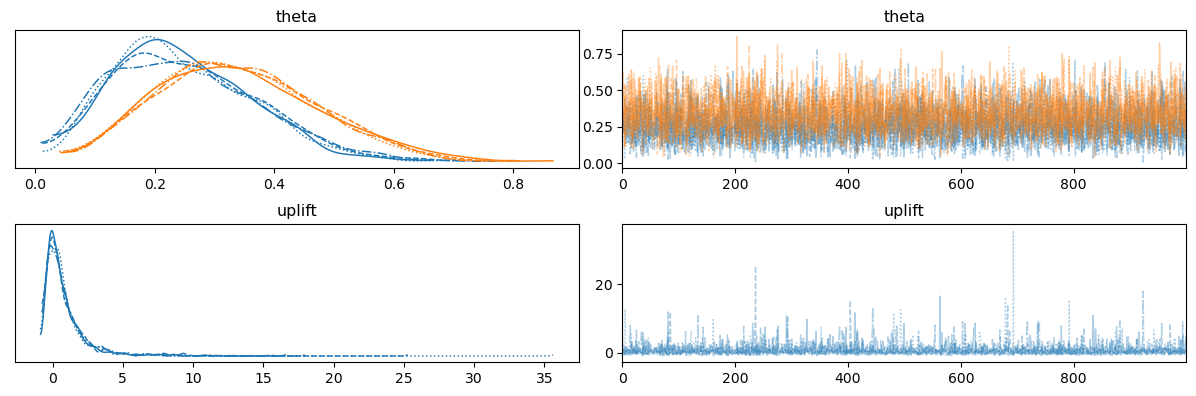

In [13]:
az.plot_trace(trace, compact=True, combined=False)
plt.tight_layout();

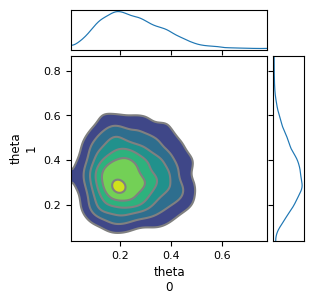

In [14]:
az.plot_pair(trace, var_names=["theta"], kind="kde", marginals=True, textsize=8, figsize=(3, 3));

In [15]:
print('probability that theta_B > theta_A: ', 100*np.mean(trace.posterior.uplift>0).values)

probability that theta_B > theta_A:  69.025


In [16]:
def ReLU(x):
    return x * (x > 0)

In [34]:
x_A = np.reshape(trace.posterior.theta[:,:,0], (4000,1)).values 
x_B = np.reshape(trace.posterior.theta[:,:,1], (4000,1)).values

x = x_A - x_B

lossFunctionA = np.mean(ReLU(-x))
lossFunctionB = np.mean(ReLU(x))

print('loss function if A is deployed: ', 100*np.round(lossFunctionA,2))
print('loss function if B is deployed: ', 100*np.round(lossFunctionB,2))

loss function if A is deployed:  12.0
loss function if B is deployed:  4.0
